In [72]:
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

In [73]:
import tensorflow as tf

In [74]:
# tf.compat.v1.disable_eager_execution()

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split


## Read train and test dataset, then shuffle it

In [76]:
SG_df = pd.read_csv("/content/drive/My Drive/Hackaton/SG_car_cleaned.csv", parse_dates=['pingtimestamp', 'pickup_time', 'dropoff_time'])

In [77]:
SG_df = SG_df.drop(columns=['Unnamed: 0', 'pingtimestamp', 'pickup_time', 'dropoff_time'])

In [78]:
SG_df

,Unnamed: 0.1,trj_id,osname,latitude,longitude,speed,bearing,accuracy,timestamp,travel_time,latitude_origin,longitude_origin,latitude_destination,longitude_destination,hour_of_day,day_of_week,is_weekend,is_weekday,is_wee_hours,is_rush_hours_morning,is_rush_hours_evening,sin_hour_of_day,cos_hour_of_day,sin_day_of_week,cos_day_of_week,haversine_km,haversine_m,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1
0,0,2,android,1.270377,103.857875,25.623161,100,32.000,2019-04-09 02:38:48+00:00,1520.0,1.270377,103.857875,1.446609,103.806354,2,1,0,1,0,0,0,5.000000e-01,0.866025,0.781831,0.623490,20.403093,12.677028,-0.025486,-0.076384,0.041837,0.094437
1,1134,3,ios,1.282591,103.851082,0.000000,96,30.000,2019-04-12 08:32:16+00:00,1158.0,1.282591,103.851082,1.332855,103.977278,8,4,0,1,0,0,0,8.660254e-01,-0.500000,-0.433884,-0.900969,15.091547,9.376812,-0.017611,-0.064838,-0.138717,-0.003314
2,2067,4,android,1.355363,103.863157,5.960000,217,3.900,2019-04-13 10:42:40+00:00,1366.0,1.355363,103.863157,1.343218,103.858504,10,5,1,0,0,0,1,5.000000e-01,-0.866025,-0.974928,-0.222521,1.445192,0.897939,-0.023023,0.008731,-0.019494,-0.003787
3,2946,5,ios,1.340301,103.775742,4.760463,91,6.000,2019-04-20 01:39:08+00:00,1328.0,1.340301,103.775742,1.303071,103.900220,1,5,1,0,0,0,0,2.588190e-01,0.965926,-0.974928,-0.222521,14.434456,8.968542,0.062661,-0.014213,-0.064685,-0.039977
4,4107,8,android,1.333936,103.953225,15.250000,318,4.288,2019-04-11 07:24:34+00:00,1210.0,1.333936,103.953225,1.309601,103.833983,7,3,0,1,0,0,0,9.659258e-01,-0.258819,0.433884,-0.900969,13.520439,8.400637,-0.114666,-0.004423,0.001871,-0.039493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27537,30323980,83955,android,1.396872,103.747718,11.609461,191,3.900,2019-04-08 22:27:51+00:00,1112.0,1.396872,103.747718,1.319548,103.843496,22,0,0,1,0,0,0,-5.000000e-01,0.866025,0.000000,1.000000,13.676692,8.497722,0.095710,0.039577,-0.006699,-0.028723
27538,30325037,83956,ios,1.396533,103.747537,3.212061,196,6.000,2019-04-09 22:09:13+00:00,983.0,1.396533,103.747537,1.322236,103.841737,22,1,0,1,0,0,0,-5.000000e-01,0.866025,0.781831,0.623490,13.329784,8.282178,0.095859,0.039224,-0.004703,-0.026205
27539,30325931,83957,android,1.301317,103.899443,11.049027,244,5.600,2019-04-21 01:20:41+00:00,1382.0,1.301317,103.899443,1.410657,103.778843,1,6,1,0,0,0,0,2.588190e-01,0.965926,-0.781831,0.623490,18.086938,11.237934,-0.064071,-0.041795,0.065966,0.056133
27540,30327120,83999,android,1.298612,103.853801,0.000000,0,4.137,2019-04-17 11:22:25+00:00,1212.0,1.298612,103.853801,1.341311,103.981728,11,2,0,1,0,0,1,2.588190e-01,-0.965926,0.974928,-0.222521,14.983214,9.309501,-0.018864,-0.048636,-0.142380,0.005511


In [79]:
min_latitude_origin = min(SG_df['latitude_origin'])
min_latitude_destination = min(SG_df['latitude_destination'])
min_latitude = min(min_latitude_origin, min_latitude_destination)

max_latitude_origin = max(SG_df['latitude_origin'])
max_latitude_destination = max(SG_df['latitude_destination'])
max_latitude = max(max_latitude_origin, max_latitude_destination)

min_longitude_origin = min(SG_df['longitude_origin'])
min_longitude_destination = min(SG_df['longitude_destination'])
min_longitude = min(min_longitude_origin, min_longitude_destination)

max_longitude_origin = max(SG_df['longitude_origin'])
max_longitude_destination = max(SG_df['longitude_destination'])
max_longitude = max(max_longitude_origin, max_longitude_destination)


In [80]:
def train_test_split(df, percent_split):
  """split the df into train and test dataframe with
  the number of data in train and test will be equals to:
  train_df: df[:int(n*percent_split)]
  test_df: df[int(percent_split*n):]

  Parameters
    df [pandas DataFrame] -- the dataset that we want to split
    percent_split [int in range [0,1]] -- percentage of data we want to use for training
  """
  df = df.reindex(np.random.permutation(df.index)) # shuffle the examples
  split = int(len(df) * percent_split)
  train_df = df[:split]
  test_df = df[split:]
  return train_df, test_df

percent_split = 0.7
train_df, test_df = train_test_split(SG_df, percent_split)
print(len(train_df))
print(len(test_df))

19279
8263


In [81]:
train_df

,Unnamed: 0.1,trj_id,osname,latitude,longitude,speed,bearing,accuracy,timestamp,travel_time,latitude_origin,longitude_origin,latitude_destination,longitude_destination,hour_of_day,day_of_week,is_weekend,is_weekday,is_wee_hours,is_rush_hours_morning,is_rush_hours_evening,sin_hour_of_day,cos_hour_of_day,sin_day_of_week,cos_day_of_week,haversine_km,haversine_m,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1
21211,23352831,71962,ios,1.310407,103.634206,16.159996,293,8.000,2019-04-10 07:53:55+00:00,985.0,1.310407,103.634206,1.326176,103.740258,7,2,0,1,0,0,0,9.659258e-01,-0.258819,0.974928,-0.222521,11.911441,7.400921,0.200895,-0.056845,0.096715,-0.031504
23897,26290290,76575,ios,1.384176,103.759799,12.000000,237,10.000,2019-04-09 12:57:19+00:00,1174.0,1.384176,103.759799,1.330831,103.916195,12,1,0,1,0,0,0,1.224647e-16,-1.000000,0.781831,0.623490,18.358101,11.406415,0.082526,0.028032,-0.078071,-0.010880
1347,1468094,2511,ios,1.303727,103.787585,5.378273,7,13.000,2019-04-08 14:04:49+00:00,1049.0,1.303727,103.787585,1.422651,103.772677,14,0,0,1,0,0,0,-5.000000e-01,-0.866025,0.000000,1.000000,13.318851,8.275385,0.047543,-0.049560,0.073197,0.067518
14928,16475192,61573,ios,1.424062,103.792345,25.790001,128,10.000,2019-04-09 21:02:26+00:00,878.0,1.424062,103.792345,1.299248,103.830303,21,1,0,1,1,0,0,-7.071068e-01,0.707107,0.781831,0.623490,14.496774,9.007262,0.053739,0.070710,0.004595,-0.050138
22483,24753691,74063,android,1.352877,103.737114,18.833382,159,4.000,2019-04-13 03:48:46+00:00,1053.0,1.352877,103.737114,1.287915,103.845396,3,5,1,0,0,0,0,7.071068e-01,0.707107,-0.974928,-0.222521,14.029520,8.716944,0.102273,-0.005200,-0.011466,-0.060053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4597,5069767,23098,ios,1.290884,103.861020,7.100000,166,10.000,2019-04-17 09:32:39+00:00,1352.0,1.290884,103.861020,1.301869,103.775367,9,2,0,1,0,0,1,7.071068e-01,-0.707107,0.974928,-0.222521,9.593747,5.960871,-0.026755,-0.055676,0.059542,-0.052520
16631,18330095,64634,ios,1.330762,103.784206,14.734765,320,8.000,2019-04-12 09:56:52+00:00,999.0,1.330762,103.784206,1.330254,103.679770,9,4,0,1,0,0,1,7.071068e-01,-0.707107,-0.433884,-0.900969,11.602456,7.208939,0.053365,-0.022943,0.157323,-0.032940
27027,29753626,82889,android,1.341920,103.696605,6.610000,55,4.288,2019-04-18 12:47:08+00:00,1811.0,1.341920,103.696605,1.380292,103.904223,12,3,0,1,0,0,0,1.224647e-16,-1.000000,0.433884,-0.900969,23.455947,14.573854,0.141618,-0.019793,-0.061654,0.037288
9847,10880936,43349,ios,1.343917,103.744893,20.358530,118,8.000,2019-04-14 05:42:04+00:00,1061.0,1.343917,103.744893,1.299268,103.845264,5,6,1,0,0,0,0,9.659258e-01,0.258819,-0.781831,0.623490,12.204735,7.583153,0.093711,-0.013416,-0.010302,-0.048758


## Represent Data
we will do feature cross between rawlat and rawlon for pickup and dropoff

## Standardize latitude and longitude

In [82]:
train_df

,Unnamed: 0.1,trj_id,osname,latitude,longitude,speed,bearing,accuracy,timestamp,travel_time,latitude_origin,longitude_origin,latitude_destination,longitude_destination,hour_of_day,day_of_week,is_weekend,is_weekday,is_wee_hours,is_rush_hours_morning,is_rush_hours_evening,sin_hour_of_day,cos_hour_of_day,sin_day_of_week,cos_day_of_week,haversine_km,haversine_m,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1
21211,23352831,71962,ios,1.310407,103.634206,16.159996,293,8.000,2019-04-10 07:53:55+00:00,985.0,1.310407,103.634206,1.326176,103.740258,7,2,0,1,0,0,0,9.659258e-01,-0.258819,0.974928,-0.222521,11.911441,7.400921,0.200895,-0.056845,0.096715,-0.031504
23897,26290290,76575,ios,1.384176,103.759799,12.000000,237,10.000,2019-04-09 12:57:19+00:00,1174.0,1.384176,103.759799,1.330831,103.916195,12,1,0,1,0,0,0,1.224647e-16,-1.000000,0.781831,0.623490,18.358101,11.406415,0.082526,0.028032,-0.078071,-0.010880
1347,1468094,2511,ios,1.303727,103.787585,5.378273,7,13.000,2019-04-08 14:04:49+00:00,1049.0,1.303727,103.787585,1.422651,103.772677,14,0,0,1,0,0,0,-5.000000e-01,-0.866025,0.000000,1.000000,13.318851,8.275385,0.047543,-0.049560,0.073197,0.067518
14928,16475192,61573,ios,1.424062,103.792345,25.790001,128,10.000,2019-04-09 21:02:26+00:00,878.0,1.424062,103.792345,1.299248,103.830303,21,1,0,1,1,0,0,-7.071068e-01,0.707107,0.781831,0.623490,14.496774,9.007262,0.053739,0.070710,0.004595,-0.050138
22483,24753691,74063,android,1.352877,103.737114,18.833382,159,4.000,2019-04-13 03:48:46+00:00,1053.0,1.352877,103.737114,1.287915,103.845396,3,5,1,0,0,0,0,7.071068e-01,0.707107,-0.974928,-0.222521,14.029520,8.716944,0.102273,-0.005200,-0.011466,-0.060053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4597,5069767,23098,ios,1.290884,103.861020,7.100000,166,10.000,2019-04-17 09:32:39+00:00,1352.0,1.290884,103.861020,1.301869,103.775367,9,2,0,1,0,0,1,7.071068e-01,-0.707107,0.974928,-0.222521,9.593747,5.960871,-0.026755,-0.055676,0.059542,-0.052520
16631,18330095,64634,ios,1.330762,103.784206,14.734765,320,8.000,2019-04-12 09:56:52+00:00,999.0,1.330762,103.784206,1.330254,103.679770,9,4,0,1,0,0,1,7.071068e-01,-0.707107,-0.433884,-0.900969,11.602456,7.208939,0.053365,-0.022943,0.157323,-0.032940
27027,29753626,82889,android,1.341920,103.696605,6.610000,55,4.288,2019-04-18 12:47:08+00:00,1811.0,1.341920,103.696605,1.380292,103.904223,12,3,0,1,0,0,0,1.224647e-16,-1.000000,0.433884,-0.900969,23.455947,14.573854,0.141618,-0.019793,-0.061654,0.037288
9847,10880936,43349,ios,1.343917,103.744893,20.358530,118,8.000,2019-04-14 05:42:04+00:00,1061.0,1.343917,103.744893,1.299268,103.845264,5,6,1,0,0,0,0,9.659258e-01,0.258819,-0.781831,0.623490,12.204735,7.583153,0.093711,-0.013416,-0.010302,-0.048758


## Create a features column for training
since we already normalized the latitude and longitude into Z-score, we will need to divide the latitude and longitude into bucket of bins with its resolution in Z(think of resolution in Z in similar way of Depth Per Inch in a screen-which is how many numper of pixel contains in an inch). the higher resolution in Z will contain more latitude and longitude per bins.

In [83]:
# Create an empty list that will eventually hold all created feature columns.
feature_columns = []

# resolution_in_degree of 1 corresponds to 
# a full standard deviation. 
resolution_in_degree = 0.00001

# Create a bucket feature column for latitude.
pickup_latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude_origin")
pickup_latitude_boundaries = list(np.arange(min_latitude_origin, 
                                     max_latitude_origin, 
                                     resolution_in_degree))

print(pickup_latitude_boundaries)
pickup_latitude = tf.feature_column.bucketized_column(pickup_latitude_as_a_numeric_column, pickup_latitude_boundaries)

# drop off latitude
dropoff_latitude_as_a_numeric_column = tf.feature_column.numeric_column("latitude_destination")
dropoff_latitude_boundaries = list(np.arange(min_latitude_destination, 
                                     max_latitude_destination, 
                                     resolution_in_degree))
dropoff_latitude = tf.feature_column.bucketized_column(dropoff_latitude_as_a_numeric_column, dropoff_latitude_boundaries)

# Create a bucket feature column for longitude.
pickup_longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude_origin")
pickup_longitude_boundaries = list(np.arange(min_longitude_origin, 
                                     max_longitude_origin, 
                                     resolution_in_degree))
pickup_longitude = tf.feature_column.bucketized_column(pickup_longitude_as_a_numeric_column, pickup_longitude_boundaries)


dropoff_longitude_as_a_numeric_column = tf.feature_column.numeric_column("longitude_destination")
dropoff_longitude_boundaries = list(np.arange(min_longitude_destination, 
                                      max_longitude_destination, 
                                      resolution_in_degree))
dropoff_longitude = tf.feature_column.bucketized_column(dropoff_longitude_as_a_numeric_column, 
                                                dropoff_longitude_boundaries)

# Create a feature cross of latitude and longitude.
pickup_latitude_x_pickup_longitude = tf.feature_column.crossed_column([pickup_latitude, pickup_longitude], hash_bucket_size=150)
crossed_pickup_feature = tf.feature_column.indicator_column(pickup_latitude_x_pickup_longitude)
feature_columns.append(crossed_pickup_feature)  

# cross dropoff feature
dropoff_latitude_x_dropoff_longitude = tf.feature_column.crossed_column([dropoff_latitude, dropoff_longitude], hash_bucket_size=150)
crossed_dropoff_feature = tf.feature_column.indicator_column(dropoff_latitude_x_dropoff_longitude)
feature_columns.append(crossed_dropoff_feature) 



[1.2441575, 1.2441675, 1.2441775000000002, 1.2441875000000002, 1.2441975000000003, 1.2442075000000004, 1.2442175000000004, 1.2442275000000005, 1.2442375000000006, 1.2442475000000006, 1.2442575000000007, 1.2442675000000007, 1.2442775000000008, 1.2442875000000009, 1.244297500000001, 1.244307500000001, 1.244317500000001, 1.2443275000000011, 1.2443375000000012, 1.2443475000000013, 1.2443575000000013, 1.2443675000000014, 1.2443775000000015, 1.2443875000000015, 1.2443975000000016, 1.2444075000000017, 1.2444175000000017, 1.2444275000000018, 1.2444375000000019, 1.244447500000002, 1.244457500000002, 1.244467500000002, 1.2444775000000021, 1.2444875000000022, 1.2444975000000023, 1.2445075000000023, 1.2445175000000024, 1.2445275000000025, 1.2445375000000025, 1.2445475000000026, 1.2445575000000026, 1.2445675000000027, 1.2445775000000028, 1.2445875000000028, 1.244597500000003, 1.244607500000003, 1.244617500000003, 1.244627500000003, 1.2446375000000032, 1.2446475000000032, 1.2446575000000033, 1.24466

In [84]:
feature_columns

[IndicatorColumn(categorical_column=CrossedColumn(keys=(BucketizedColumn(source_column=NumericColumn(key='latitude_origin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1.2441575, 1.2441675, 1.2441775000000002, 1.2441875000000002, 1.2441975000000003, 1.2442075000000004, 1.2442175000000004, 1.2442275000000005, 1.2442375000000006, 1.2442475000000006, 1.2442575000000007, 1.2442675000000007, 1.2442775000000008, 1.2442875000000009, 1.244297500000001, 1.244307500000001, 1.244317500000001, 1.2443275000000011, 1.2443375000000012, 1.2443475000000013, 1.2443575000000013, 1.2443675000000014, 1.2443775000000015, 1.2443875000000015, 1.2443975000000016, 1.2444075000000017, 1.2444175000000017, 1.2444275000000018, 1.2444375000000019, 1.244447500000002, 1.244457500000002, 1.244467500000002, 1.2444775000000021, 1.2444875000000022, 1.2444975000000023, 1.2445075000000023, 1.2445175000000024, 1.2445275000000025, 1.2445375000000025, 1.2445475000000026, 1.244557500000002

In [85]:
# Create numeric column for time in day and hour.

# Represent sin and cos of hour as a floating-point value.
sin_pickup_hour = tf.feature_column.numeric_column("sin_hour_of_day")
feature_columns.append(sin_pickup_hour)

cos_pickup_hour = tf.feature_column.numeric_column("cos_hour_of_day")
feature_columns.append(cos_pickup_hour)

# Represent sin and cos of day as a floating-point value.
sin_pickup_day = tf.feature_column.numeric_column("sin_day_of_week")
feature_columns.append(sin_pickup_day)

cos_pickup_day = tf.feature_column.numeric_column("cos_day_of_week")
feature_columns.append(cos_pickup_day)

#haversine distance
haversine_m = tf.feature_column.numeric_column("haversine_m")
feature_columns.append(haversine_m)

haversine_km = tf.feature_column.numeric_column("haversine_km")
feature_columns.append(haversine_km)

my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

# Build Densenet baseline model

## Define plotting function

In [86]:
def plot_loss_curve(epochs, rmse, label):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label=label)
  plt.legend()
  plt.ylim([rmse.min()*0.95, rmse.max() * 1.03])
  plt.show()  


## Create our densenet model

In [87]:
def create_model(feature_layer, learning_rate=0.00001):
  leaky_relu_alpha = 0.1
  model = tf.keras.models.Sequential()

  # Add layer containing the feature columns to the layer
  model.add(feature_layer)

  model.add(tf.keras.layers.Dropout(.05, input_shape=(2,)))
  # Define first hidden layer with 500 node
  model.add(tf.keras.layers.Dense(units=500,
                                  name='Hidden1'))
  # Define leaky relu activation layer
  model.add(tf.keras.layers.LeakyReLU(alpha=leaky_relu_alpha))

  model.add(tf.keras.layers.Dropout(.1, input_shape=(2,)))
  # Define second hidden layer with 300 node
  model.add(tf.keras.layers.Dense(units=300, 
                                  name='Hidden2'))
  
  # Define leaky relu activation layer
  model.add(tf.keras.layers.LeakyReLU(alpha=leaky_relu_alpha))

  model.add(tf.keras.layers.Dropout(.1, input_shape=(2,)))
  # Define third hidden layer with 80 node
  model.add(tf.keras.layers.Dense(units=80,
                                  name='Hidden3'))
  
  # Define leaky relu activation layer
  model.add(tf.keras.layers.LeakyReLU(alpha=leaky_relu_alpha))

  model.add(tf.keras.layers.Dropout(.02, input_shape=(2,)))
  # Define fourth hidden layer with 50 node
  model.add(tf.keras.layers.Dense(units=50,
                                  name='Hidden4'))
  
  # Define leaky relu activation layer
  model.add(tf.keras.layers.LeakyReLU(alpha=leaky_relu_alpha))

  model.add(tf.keras.layers.Dropout(.01, input_shape=(2,)))
  # Define fifth hidden layer with 50 node
  model.add(tf.keras.layers.Dense(units=20,
                                  name='Hidden5'))
  
  # Define leaky relu activation layer
  model.add(tf.keras.layers.LeakyReLU(alpha=leaky_relu_alpha))

  # Define output layer
  model.add(tf.keras.layers.Dense(units=1,
                                  name='Output'))
  
  # Construct the layers into a model that TensorFlow can execute.
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])
  
  return model

## Define training function.

In [88]:
def train_model(model, dataset, epochs, train_label,
                batch_size, validation_split=0.3):
  
  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))

  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, validation_split=validation_split)
  
  # list of epochs of the model
  epochs = history.epoch

  #gather snapshot of the model's mean squared error
  # at each epoch.
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, hist

In [89]:
import timeit

# Train Densenet model

Epoch 1/120

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

68/68 [==============================] - 1s 15ms/step - loss: 1576628.7500 - root_mean_squared_error: 1255.6388 - val_loss: 1539779.6250 - val_root_mean_squared_error: 1240.8785
Epoch 2/120
68/68 [==============================] - 1s 8ms/step - loss: 1530280.0000 - root_mean_squared_error: 1237.0449 - val_loss: 1457109.3750 - val_root_mean_squared_error: 1207.1079
Epoch 3/120
68/68 [==============================] - 1s 8ms/step - loss: 1368120.8750 - root_mean_squared_error: 1169.6670 - val_

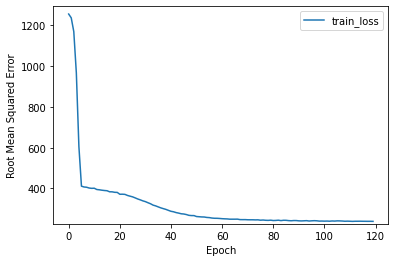

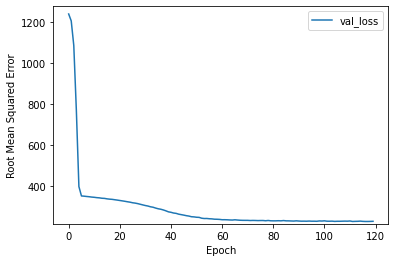

In [90]:
batch_size = 200
epochs = 120
learning_rate = 0.00005

# Specify the label
label_name = "travel_time"

# Establish model's topography
my_model = create_model(my_feature_layer, learning_rate)

# Train the model on normalized training set
starttime = timeit.default_timer()
epochs, hist = train_model(my_model, train_df, epochs, label_name,
                batch_size)
endtime = timeit.default_timer()

print("Time taken for training: {} seconds".format(endtime-starttime))
# plot RMSE curve
plot_loss_curve(epochs, hist.root_mean_squared_error, "train_loss")
plot_loss_curve(epochs, hist.val_root_mean_squared_error, "val_loss")

In [91]:
# After building a model against the training set, test that model
# against the test set.
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x = test_features, y = test_label, batch_size=batch_size)


 Evaluate the new model against the test set:
42/42 [==============================] - 0s 5ms/step - loss: 54877.1406 - root_mean_squared_error: 234.2587


[54877.140625, 234.25869750976562]